In [1]:
import scipy.io
import cv2
import shutil
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy.io import loadmat

In [2]:
folder= 'VOC2010/'
IMG_PATH = folder+'JPEGImages/'
ANN_PATH = folder+'Annotations_Part/'

In [3]:
file_train = folder+'ImageSets/Main/train.txt'
file_val = folder+'ImageSets/Main/val.txt'

files_train = pd.read_csv(file_train, sep=' ', names=['file'])
files_train['split'] = 'train'
files_val = pd.read_csv(file_val, sep=' ', names=['file'])
files_val['split'] = 'val'

files = pd.concat([files_train, files_val], ignore_index=True)

classes = [c.split('_')[0] for c in os.listdir(folder+'ImageSets/Main') if c.endswith('_train.txt')]

In [4]:
animals = ['sheep', 'dog', 'cow', 'cat', 'horse']

# Process VOC2010 dataset

In [5]:
columns=['file', 'split', 'per_occ', 'detections', 'img_w', 'img_h', 'animals'] + classes
df = pd.DataFrame(columns = columns)

counter = 0

for index, row in files.iterrows():
    f_name=row.file
    if os.path.isfile(ANN_PATH+f_name+'.mat'):
        counter += 1
        mat_file = loadmat(ANN_PATH+f_name+'.mat')

        classes_info = np.zeros(len(classes), np.int32)
        final_mask = np.zeros(mat_file['anno'][0][0][1][0][0][2].shape, np.int8)
        animals_count = 0
        for detection in mat_file['anno'][0][0][1][0]:
            cat, cat_id, mask, mask_parts = detection
            classes_info[cat_id[0][0]-1] += 1
            final_mask = np.logical_or(final_mask, mask)
            if cat in animals:
                animals_count += 1
        per_occ = final_mask.sum()/(final_mask.shape[0]*final_mask.shape[1])
       
        info = np.concatenate([[f_name, row.split, per_occ, len(mat_file['anno'][0][0][1][0]),final_mask.shape[1], final_mask.shape[0], animals_count], classes_info])    
        df_row = pd.DataFrame([info], columns=columns)
        df = pd.concat([df, df_row], axis=0)

cols_int = ['detections', 'img_w', 'img_h'] + classes
df[cols_int] = df[cols_int].astype(int)

# Guardar el CSV
df.to_csv('voc2010_info.csv', index=False)


KeyboardInterrupt



# Filter dataset

In [6]:
PATH_data = 'dataset/'
IMG_PATH_data = PATH_data+'images/'
ANN_PATH_data = PATH_data+'annotations/'

In [7]:
df = pd.read_csv('voc2010_info.csv')

Cat 	 Imgs 	 Train 	 Val 	 %Occupation
sheep 	 96 	 51 	 45 	 0.2886039996430471 0.23131196278693494 0.9744543429844098
dog 	 701 	 351 	 350 	 0.3137457986858771 0.2906366366366366 0.9953493333333332
cow 	 106 	 58 	 48 	 0.26646911903663134 0.18444466066066062 0.8629161676646706
cat 	 717 	 353 	 364 	 0.37630319767611536 0.3564429530201342 1.0
horse 	 148 	 69 	 79 	 0.28260008694909383 0.2566160833333333 0.9516696696696696


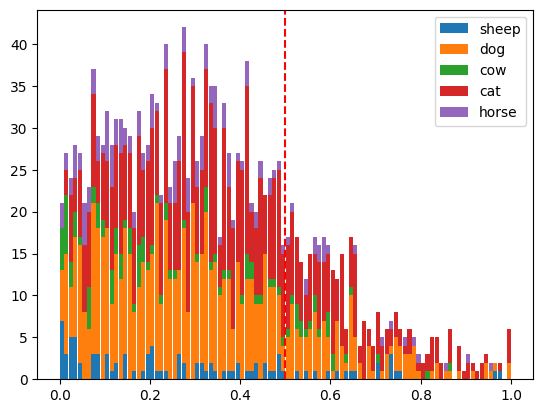

In [11]:
print('Cat', '\t', 'Imgs', '\t', 'Train', '\t','Val', '\t', '%Occupation')
bottom = np.zeros(100)
bins = np.linspace(0, 1, 101)  # 100 bins → 101 bin edges
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for a in animals:
    df_a = df[(df['detections']==1) & (df[a]>0)]
    df_at = df_a[df_a['split']=='train']
    df_av = df_a[df_a['split']=='val']
    print(a, '\t', len(df_a), '\t', len(df_at), '\t',len(df_av), '\t', df_a['per_occ'].mean(), df_a['per_occ'].median(), df_a['per_occ'].max())
    counts, _ = np.histogram(df_a['per_occ'], bins=bins)
    plt.bar(bin_centers, counts, width=0.009, bottom=bottom, label=a)
    bottom += counts
plt.legend()
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, label='0.75 threshold')
plt.show()

In [12]:
df_filter = df[(df['detections']==1) & (df['per_occ']<=0.5) & (df['animals']==1) ]#((df['cow']>0) | (df['horse']>0))]
#animals = ['sheep', 'dog', 'cow', 'cat', 'horse']

In [13]:
if os.path.exists(PATH_data):
    shutil.rmtree(PATH_data)

for p in [PATH_data, IMG_PATH_data, ANN_PATH_data]:
    os.mkdir(p)

In [14]:
columns_data=['file', 'split', 'per_occ', 'cat', 'img_w', 'img_h']
df_data = pd.DataFrame(columns = columns_data)

for index, row in df_filter.iterrows():
    if os.path.isfile(IMG_PATH+row.file+'.jpg'):
        if row.sheep == 1:
            cat = 'sheep'
        elif row.dog == 1:
            cat = 'dog'
        elif row.cow == 1:
            cat = 'cow'
        elif row.horse == 1:
            cat = 'horse'
        else:
            cat = 'cat'
        info = np.concatenate([[row.file, row.split, row.per_occ, cat ,row.img_w, row.img_h]])    
        df_row = pd.DataFrame([info], columns=columns_data)
        df_data = pd.concat([df_data, df_row], axis=0)
        shutil.copy(IMG_PATH+row.file+'.jpg', IMG_PATH_data)
        shutil.copy(ANN_PATH+row.file+'.mat', ANN_PATH_data)

df_data.to_csv('dataset_info.csv', index=False)